# No supervisado

Los modelos no supervisados carecen de variable objetivo, por lo tanto se emplean para conocer mejor el conjunto de datos, ver si presentan agrupaciones lógicas o si existen variables de las que podamos prescindir. 

## Selección de características (Feature selection)

¿Por qué es necesario seleccionar características? Para algunos, esta idea puede parecer contraintuitiva, pero hay al menos dos razones importantes para deshacerse de características sin importancia. La primera es evidente para cualquier ingeniero: cuantos más datos, mayor complejidad computacional. Mientras trabajemos con conjuntos de datos de juguete, el tamaño de los datos no es un problema, pero, para sistemas de producción con carga real, cientos de características adicionales serán bastante tangibles. La segunda razón es que algunos algoritmos toman el ruido (características no informativas) como una señal y sobreajustan.

### Aproximaciones estadísticas

El candidato más obvio para ser eliminado es un rasgo cuyo valor permanece invariable, es decir, que no contiene ninguna información. Si nos basamos en esta idea, es razonable afirmar que las características con una varianza baja son peores que las que tienen una varianza alta. Por lo tanto, se puede considerar la posibilidad de eliminar características con una varianza inferior a un determinado umbral.

Generamos un problema tipo para nuestras pruebas.

In [1]:
from sklearn.datasets import make_classification

x_data_generated, y_data_generated = make_classification(random_state=2)
x_data_generated.shape

(100, 20)

#### VarianceThreshold

- **¿Qué es?**: Una técnica que elimina características cuya varianza no alcanza un umbral especificado.
- **Funcionamiento**: Calcula la varianza de cada característica y elimina aquellas que no superan el umbral establecido. Esto significa que las características que apenas cambian entre muestras (es decir, tienen baja varianza) se descartarán.
- **Ventajas**: Rápida y fácil de usar, útil cuando las características con baja varianza no son informativas.
- **Limitaciones**: No considera la relación con la variable objetivo, puede eliminar características útiles.

In [2]:
from sklearn.feature_selection import VarianceThreshold

primer_filtro = VarianceThreshold(.7).fit_transform(x_data_generated)
primer_filtro.shape

(100, 20)

In [3]:
primer_filtro = VarianceThreshold(.9).fit_transform(x_data_generated)
primer_filtro.shape

(100, 14)

In [4]:
primer_filtro = VarianceThreshold(.99).fit_transform(x_data_generated)
primer_filtro.shape

(100, 11)

#### SelectKBest

- **¿Qué es?**: Selecciona las K mejores características basadas en algún criterio de puntuación.
- **Funcionamiento**: Calcula una puntuación para cada característica en función de algún criterio (como la prueba F para la regresión lineal o la puntuación chi-cuadrado para la clasificación). Luego, selecciona las K características con las puntuaciones más altas.
- **Ventajas**: Permite seleccionar características en función de su relevancia con respecto a la variable objetivo.
- **Limitaciones**: Puede ser costoso para conjuntos de datos grandes, elección subjetiva de K.

In [5]:
from sklearn.feature_selection import SelectKBest

x_data_kbest = SelectKBest(k=5).fit_transform(x_data_generated, y_data_generated)
x_data_kbest.shape

(100, 5)

In [6]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

logit = LogisticRegression(random_state=42)
coss_val_res = cross_val_score(logit, x_data_generated, y_data_generated, cv=5)
np.mean(coss_val_res)

np.float64(0.8800000000000001)

In [7]:
coss_val_res = cross_val_score(logit, x_data_kbest, y_data_generated, cv=5)
np.mean(coss_val_res)

np.float64(0.86)

In [8]:
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)
coss_val_res = cross_val_score(logit, x_data_varth, y_data_generated, cv=5)
np.mean(coss_val_res)

np.float64(0.89)

#### RFE (Recursive Feature Elimination)

- **¿Qué es?**: Elimina recursivamente las características menos importantes hasta alcanzar el número deseado.
- **Funcionamiento**: Entrena un modelo (generalmente un modelo de aprendizaje automático) en todas las características y luego elimina las características con menor importancia. Este proceso se repite hasta que se alcanza el número deseado de características.
- **Ventajas**: Considera la interacción entre características, puede ser más robusto.
- **Limitaciones**: Puede ser costoso computacionalmente, elección del modelo y número de características.

In [9]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

svc = SVC(kernel="linear", C=1)
rfe = RFE(estimator=svc, n_features_to_select=10, step=1)
rfe.fit(x_data_generated, y_data_generated)

,estimator,"SVC(C=1, kernel='linear')"
,n_features_to_select,10
,step,1
,verbose,0
,importance_getter,'auto'
,C,1
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True


In [10]:
x_rfe = rfe.transform(x_data_generated)
x_rfe.shape

(100, 10)

In [11]:
coss_val_res = cross_val_score(logit, x_rfe, y_data_generated, cv=5)
np.mean(coss_val_res)

np.float64(0.8700000000000001)

In [12]:
x_data_varth = VarianceThreshold(.9).fit_transform(x_data_generated)
coss_val_res = cross_val_score(svc, x_data_varth, y_data_generated, cv=5)
np.mean(coss_val_res)

np.float64(0.9)

## Principal Component Analysis (PCA)

El análisis de componentes principales permite reducir las dimensiones de las muestras originales creando nuevas componentes que concentren la varianza del conjunto de datos original. Si elimináramos características al azar, perderíamos información. Esto sucede casi siempre que eliminamos características de nuestro conjunto de datos pero la idea de concentrar la varianza en componentes concretas hace que suprimir las componentes menos informativas reduzca la cantidad de información perdida con respecto al ruido que también aportan las mismas variables, destilando así nuestro conjunto de datos original.

La coravianza entre dos variables (atributos de nuestras muestras o columnas de nuestro dataframe) se define como:

$$

Cov(X, Y) = E[(X - E[X])(Y - E[Y])]

$$
donde $n$ representa el numero total de datos. De modo que la matriz de covarianza muestra los valores asociados a cada par de muestras en una matriz de $n \times n$ donde $Cov(x_i, x_i) = Var(X_i) = \sigma_{X_i}^2$. Esta matriz caracteriza la variabilidad de nuestro conjunto de datos, de manera que encontrando su autovector de mayor autovalor podemos condensar en una única combinación lineal de los atributos su máximo contenido informativo. Los autovalores y autovectores son claves a la hora de descomponer una matriz. Cumplen la relación

$$

Av = \lambda v

$$
siendo $\lambda$ un valor scalar y $v$ un vector, de manera que caracterizan de forma particular la variabilidad de nuestras muestras de datos. Os dejamos algo más de información en [este enlace](https://aga.frba.utn.edu.ar/autovalores-autovectores-definiciones-propiedades/).

<center>

![pca](../../assets/images/640px-GaussianScatterPCA.svg.webp)

</center>

Dado que no es trivial familiarizarse con la descomposición de matrices, veamos un ejemplo práctico. Vamos a reducir imágenes a dos componentes y ver qué resulta de la reconstrucción.

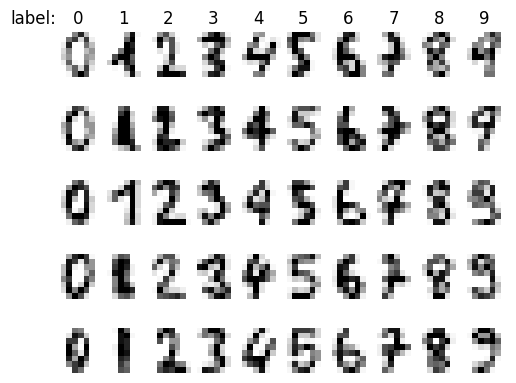

In [21]:
from visualize import plot_dataset
from sklearn.datasets import load_digits
 
digits = load_digits()
data = digits.data

plot_dataset(digits.data, digits.target, rows=5)

In [26]:
data.shape

(1797, 64)

In [29]:
from sklearn.decomposition import PCA

pca = PCA(2)
converted_data = pca.fit_transform(digits.data)

In [30]:
converted_data.shape

(1797, 2)

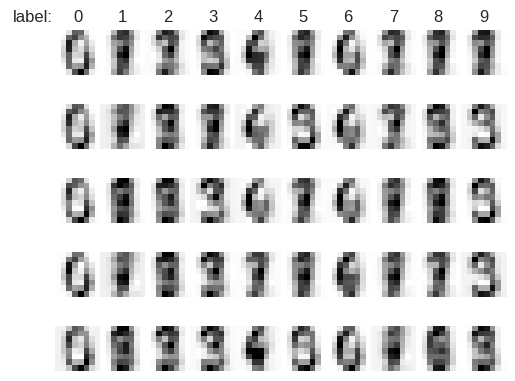

In [31]:
reconstruccion = pca.inverse_transform(converted_data)

plot_dataset(reconstruccion, digits.target, rows=5)

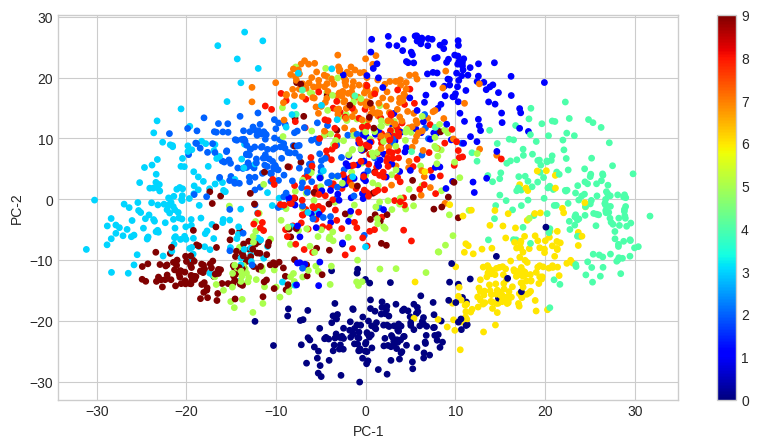

In [32]:
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize = (10,5))
c_map = matplotlib.colormaps.get_cmap('jet')
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 15,
            cmap = c_map , c = digits.target)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
plt.show();

In [33]:
X = converted_data[:, 0:2]
y = digits.target

In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X, y)
knn.score(X, y)

0.7301057317751809

Tenéis aquí algo más de referencia sobre este conjunto en particular: https://colah.github.io/posts/2014-10-Visualizing-MNIST/

# Clustering

El clustering o segmentación es la tarea de agrupar las muestras en base a su proximidad y componer así agrupaciones de elementos similares. Esta técnica permite por ejemplo conocer clientes que pertenecen a una agrupación y obtener el cliente tipo de dicha agrupación. También permite segregar los datos para así componer modelos específicos en cada cohorte. Es una técnica muy empleada cuando disponemos de multitud de datos y queremos estudiar si existen similitudes entre las muestras que permitan reducir el número de muestras a emplear en el estudio.

Existen multiples algoritmos aunque nosotros nos centraremos en los más populares y empleados.

https://scikit-learn.org/stable/modules/clustering.html

## Classification _vs_ Clustering

In [1]:
from sklearn.datasets import load_iris

data = load_iris()
X = data.data
y = data.target
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

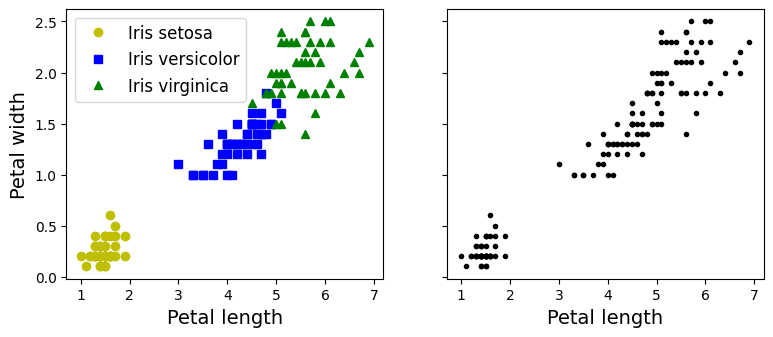

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 3.5))

plt.subplot(121)
plt.plot(X[y==0, 2], X[y==0, 3], "yo", label="Iris setosa")
plt.plot(X[y==1, 2], X[y==1, 3], "bs", label="Iris versicolor")
plt.plot(X[y==2, 2], X[y==2, 3], "g^", label="Iris virginica")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(fontsize=12)

plt.subplot(122)
plt.scatter(X[:, 2], X[:, 3], c="k", marker=".")
plt.xlabel("Petal length", fontsize=14)
plt.tick_params(labelleft=False)

plt.show()

A simple vista podemos ver que existe dos agrupaciones claras entre las muestras.

### K-means (k-medios)

El algoritmo k-medios es un método de agrupamiento no supervisado que se utiliza para dividir un conjunto de datos en k grupos o clusters, donde cada grupo se caracteriza por tener características similares. El objetivo es minimizar la suma de las distancias entre cada objeto y el centroide de su grupo o cluster.

El algoritmo k-medios funciona de la siguiente manera:

* Inicialización: Se escogen k centroides aleatoriamente en el espacio de los datos.
* Asignación de objetos a los centroides: cada objeto se asigna al centroide más cercano.
* Actualización de centroides: se actualiza la posición del centroide de cada grupo tomando como nuevo centroide la posición del promedio de los objetos pertenecientes a ese grupo.
* Repetición: se repiten los pasos 2 y 3 hasta que los centroides no se mueven o se mueven por debajo de una distancia umbral en cada paso.

In [3]:
from sklearn.cluster import KMeans

k = 2

kmeans = KMeans(n_clusters=k, random_state=101)
y_pred = kmeans.fit_predict(X)

In [4]:
import numpy as np

mapping = np.array([1,0,2])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

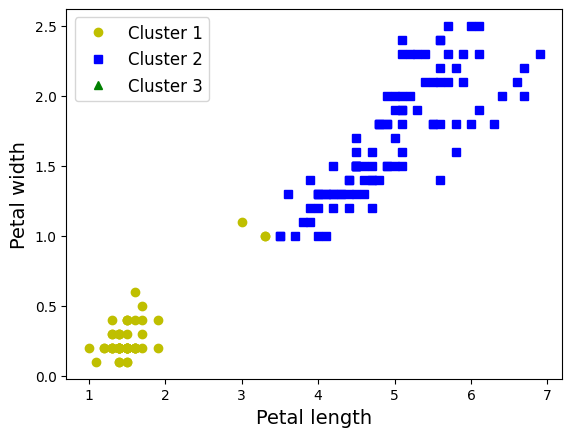

In [5]:
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

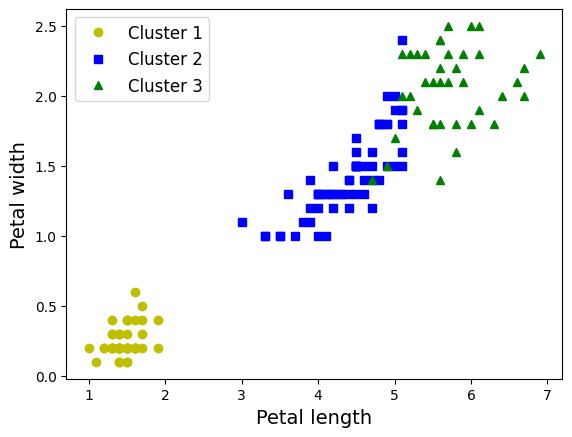

In [6]:
k = 3

kmeans = KMeans(n_clusters=k, random_state=101)
y_pred = kmeans.fit_predict(X)

mapping = np.array([2,0,1])
y_pred = np.array([mapping[cluster_id] for cluster_id in y_pred])

plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_pred, y)

array([[50,  0,  0],
       [ 0, 47, 14],
       [ 0,  3, 36]])

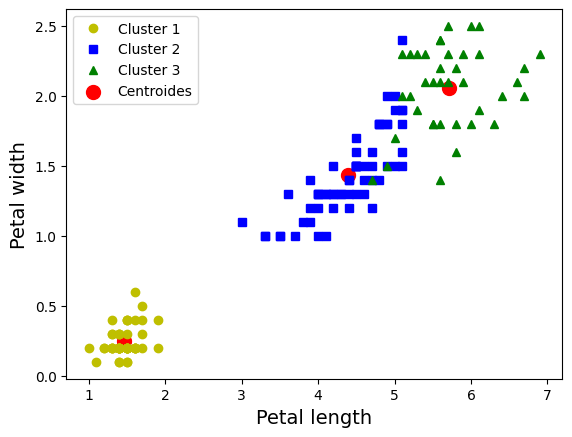

In [8]:
#Visualising the clusters
plt.plot(X[y_pred==0, 2], X[y_pred==0, 3], "yo", label="Cluster 1")
plt.plot(X[y_pred==1, 2], X[y_pred==1, 3], "bs", label="Cluster 2")
plt.plot(X[y_pred==2, 2], X[y_pred==2, 3], "g^", label="Cluster 3")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=12)

#Plotting the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:,3], s = 100, c = 'red', label = 'Centroides')

plt.legend()

Uno de los valores clave a la hora de evaluar la bondad de un modelo de clustering es la _inertia_. La inercia ($J$) mide la suma de los cuadrados de la distancia a los centrodies de los clústeres ($\mu_k$) tal que:

$$

J = \sum_{k}^{K} \sum_{i}^{n_k} \| x_i - \mu_{k} \|^2

$$

In [9]:
kmeans.inertia_

78.85566582597731

In [16]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X) for k in range(1, 7)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [17]:
import pandas as pd

df_kmeans = pd.DataFrame(inertias, columns=['inertia'])
df_kmeans['inertia_1'] = df_kmeans['inertia'].shift(1)
df_kmeans['diff%'] = df_kmeans['inertia']/df_kmeans['inertia_1']
df_kmeans

,inertia,inertia_1,diff%
0,681.370600,NaN,NaN
1,152.347952,681.370600,0.223590
2,78.855666,152.347952,0.517602
3,57.350880,78.855666,0.727289
4,46.472230,57.350880,0.810314
5,39.066035,46.472230,0.840632


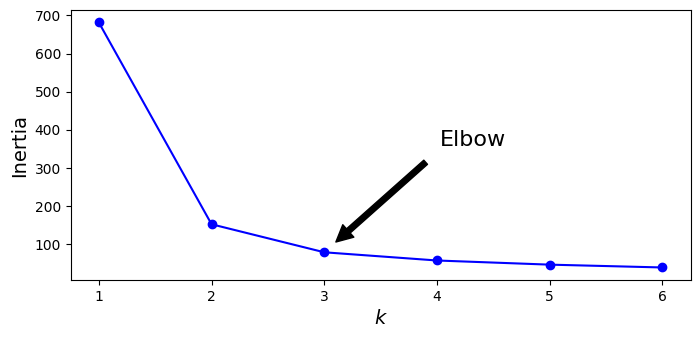

In [19]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 7), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(3, inertias[2]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

La segmentación o clustering es un mundo en si mismo. Podéis ver qué otras técnicas hay disponibles en https://scikit-learn.org/stable/modules/clustering.html